Họ tên: Nguyễn Việt Hùng

MSHV: CH1702036





                                            BÁO CÁO ĐỒ ÁN MÔN HỌC
                                    Đề tài: Bài toán nhận diện khuôn mặt

# 1. Mô tả bài toán 

Input: 
    Hình ảnh chứa nhiều khuôn mặt của nhiều người chưa biết
    Bộ dữ liệu huấn luyện gồm nhiều khuôn mặt của rất nhiều người và gán nhãn (label) là tên người đó
    
Output:
    Nhận diện ra khuôn mặt trong các bức hình trên (bounding box) và gán nhãn cho khuôn mặt đó
    Hiệu suất: tỉ lệ số khuôn mặt được nhận diện đúng so với tổng số khuôn mặt
    
Kĩ thuật sử dụng: k-nearest-neighbors (KNN)

# 2. Giải thích code

Yêu cầu:

Cài đặt một số thư viện: face_recognition, dlib, scikit-learn
Tạo thư mục chứa bộ dữ liệu huấn luyện là train_data theo cấu trúc:
<img src="images\1.png">
với label1, label2… là tên các nhãn ứng với tên mỗi người
    
Tạo các thư mục là test_data chứa hình ảnh input cần nhận diện và result_data để chứa hình ảnh output sau khi nhận diện thành công.


# Bước 1: khai báo thư viện và biến toàn cục 

In [46]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}


# Bước 2: Định nghĩa hàm train để train bộ dữ liệu huấn luyện cho quá trình nhận điện

Tham số cần truyền vào là đường dẫn tập huấn luyện (thư mục train_data), đường dẫn lưu kết quả, số neighbors

Hàm này sẽ trả về một file chứa kết quả huấn luyện cho KNN trên bộ dữ liệu train_data

Biến X là mảng chứa các khuôn mặt để huấn luyện, Y là mảng lưu đường dẫn các label trong train_data


In [47]:
def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):

    X = []
    y = []   
    i = 0
    j = 0
    # Vòng lặp for duyệt các thư mục hợp lệ chứa label trong tập huấn luyện
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue
        i = i + 1
        # Với mỗi thư mục trên tạo một vòng lặp duyệt các file hình ảnh trong đó
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            
            face_bounding_boxes = face_recognition.face_locations(image)
            # Hàm face_bounding_boxes sẽ chỉ hợp lệ nếu lấy ra đúng 1 khuôn mặt từ mỗi hình
            if len(face_bounding_boxes) != 1:
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Sau đó ta mã hóa khuôn mặt này và đưa vào tập huấn huyện (mảng X)
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)
                j = j + 1
    # Xác định số neighbors trong KNN classifier, sẽ được tự động chọn nếu không được truyền vào ở trên
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Gọi hàm neighbors.KneighborsClassifier để tạo và tập huấn cho KNN classifier trên tập huấn luyện X, ta truyền vào trọng số n_neighbors đã tính ở trên, tham số algorithm và weights
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # lưu kết quả huấn luyện của KNN classifier vào file trained_knn_model.clf
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)
    
    print("Found total: {}".format(i), "Label and {}".format(j)," face in training data")
    return knn_clf


<img src="images\2.png">




# Bước 3: định nghĩa hàm predict để nhận dạng các khuôn mặt trong hình ảnh truyền vào bằng KNN classifier đã huấn luyện ở bước 2

các tham số truyền vào gồm đường dẫn đến hình ảnh, KNN classifier, distance_threshold là 0.6 (khoảng cách để phân loại khuôn mặt, ngưỡng càng lớn thì dễ nhận dạng sai) 

Trả về danh sách các label và vị trí khuôn mặt (tọa độ bounding box) 

In [48]:
def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):

    # Kiểm tra đường dẫn hình ảnh input có hợp lệ
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))
        
    # Kiểm tra điều kiện: yêu cầu phải truyền vào tham số knn_clf ( là KNN classifier ở bước 2) hoặc đường dẫn đến đó
    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load KNN classifier  lên từ đường dẫn đã cung cấp (là file trained_knn_model.clf)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load hình ảnh cần nhận dạng lên,  
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # Trả về 0 nếu không tìm ra
    if len(X_face_locations) == 0:
        return []

    # tìm vị trí khuôn mặt.
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Gọi hàm kneighbors để tìm kết quả phù hợp nhất từ knn_clf  với các khuôn mặt cần nhận dạng.
    # Sau đó chọn ra các kết quả nằm trong ngưỡng closest_distances
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Trả về danh sách các label và vị trí khuôn mặt (tọa độ bounding box) 
    # Những khuôn mặt không nhận dạng được sẽ trả về unknown

    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]





# Bước 4: định nghĩa hàm show_prediction_labels_on_image để hiển thị các khuôn mặt nhận dạng được lên hình

Tham số truyền vào là đường dẫn hình ảnh cần nhận dạng và kết quả của hàm predict ở bước 3
Sử dụng thư viện Image và ImageDraw để vẽ label và box lên hình


In [49]:
def show_prediction_labels_on_image(image_file, predictions):
    
    #Sử dụng thư viện Image và ImageDraw để vẽ label và box lên hình
    img_path = os.path.join("test_data", image_file)
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)
    # Vòng lặp: với mỗi tên label, tọa độ vị trí khuôn mặt lấy được từ hàm predict, ta vẽ bounding box quanh khuôn mặt lên hình
    for name, (top, right, bottom, left) in predictions:
        # vẽ bounding box
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        name = name.encode("UTF-8")

        # Sau đó vẽ thêm Label bên dưới bounding box
        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 12, bottom - text_height - 5), name, fill=(255, 255, 255, 255))

    del draw

    # Cuối cùng là show kết quả là hình ảnh cần nhận dạng đã vẽ thêm bounding box và gán nhãn cho các khuôn mặt nhận dạng được
    pil_image.show()

    # lưu vào thư mục result_data
    pil_image.save(os.path.join("result_data", image_file))



# Bước 5: hàm main

 Gọi các hàm đã định nghĩa ở trên để train và nhận dạng khuôn mặt trong hình


In [50]:
if __name__ == "__main__":
    # đầu tiên ta huấn luyện KNN classifier từ bộ dữ liệu huấn luyện ở thư mục train_data và lưu lại vào file trained_knn_model.clf
    print("Training KNN classifier...")
    classifier = train("train_data", model_save_path="trained_knn_model.clf", n_neighbors=2)
    print("Training complete!\n\n")

    # Sau đó, với mỗi hình cần nhận diện trong thư mục test_data ta gọi hàm predict để nhận dạng, truyền vào kết quả huấn luyện ở bước trên.
    # Mỗi khuôn mặt nhận diện được ta đều ghi log và hiển thị tên label lên màn hình

    for image_file in os.listdir("test_data"):
        full_file_path = os.path.join("test_data", image_file)

        print("Looking for faces in {}".format(image_file))

        predictions = predict(full_file_path, model_path="trained_knn_model.clf")

        # hiển thị kết quả
        count = 0
        for name, (top, right, bottom, left) in predictions:
            print("- Found {}".format(name))
            if name != "unknown":
                count += 1

        print("Recognized {}/{} faces found".format(count, len(predictions)))
        print("===============================")

        # Cuối cùng là gọi hàm show_prediction_labels_on_image để vẽ bounding box và gán nhãn lên từng khuôn mặt lên hình và lưu vào thư mục result_data
        show_prediction_labels_on_image(image_file, predictions)


Training KNN classifier...
Found total: 28 Label and 42  face in training data
Training complete!


Looking for faces in test_1.png
- Found VULQ
- Found QUANVM
- Found HOBV
- Found DUYETLV
- Found VULQ
- Found HOAISD
- Found TULG
Recognized 7/7 faces found
Looking for faces in test_2.png
- Found NHANTH
Recognized 1/1 faces found
Looking for faces in test_3.png
- Found HANTQ
- Found TAIHPT
- Found MINHHA
- Found HOAISD
- Found QUANVM
- Found MINHHA
- Found HOBV
Recognized 7/7 faces found
Looking for faces in test_4.png
- Found MINHHA
- Found CUONGNT
- Found THAODNT
Recognized 3/3 faces found


# 3. Đánh giá kết quả

 
 Tập huấn luyện (thư mục train_data): gồm 24 label, mỗi label chứa từ 1-5 khuôn mặt
 
 Tập hình ảnh cần nhận dạng (thư mục test_data): 4 hình
 


<img src="images\test_1.png">

<img src="images\test_1.png">

<img src="images\test_1.png">

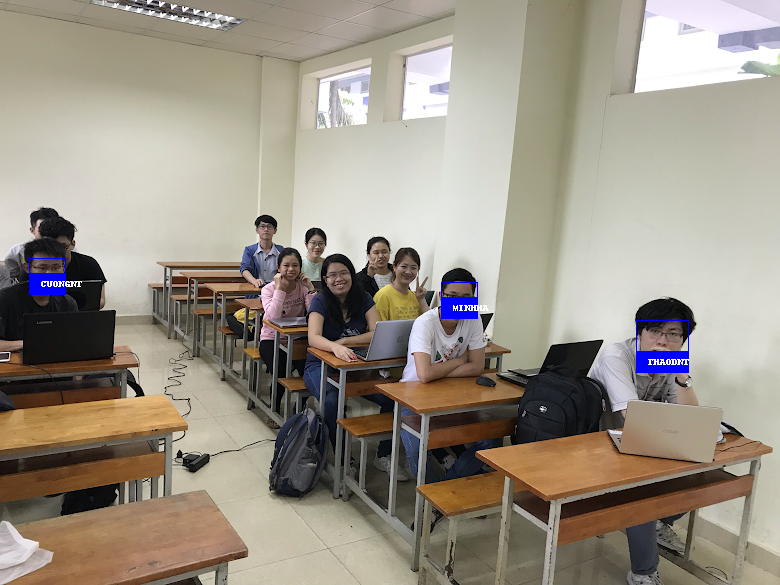

#    Kết quả: (thư mục result_data)

Hình 1: (số khuôn mặt nhận dạng đúng) / (số khuôn mặt nhận dạng được) = 4/7

Hình 2: (số khuôn mặt nhận dạng đúng) / (số khuôn mặt nhận dạng được) = 0/1

Hình 3: (số khuôn mặt nhận dạng đúng) / (số khuôn mặt nhận dạng được) = 6/7

Hình 4: (số khuôn mặt nhận dạng đúng) / (số khuôn mặt nhận dạng được) = 0/3

Tổng kết: (số khuôn mặt nhận dạng đúng) / (số khuôn mặt nhận dạng được) = 10/18

#    Nhận xét:

Ở chương trình này, kết quả (vẽ bounding box-gán label) chỉ tính cho những khuôn mặt nào mà nó nhận dạng ra được là khuôn mặt của ai, còn những khuôn mặt không biết sẽ bỏ qua, ví dụ như hình 1 ta thấy có 9 khuôn mặt nhưng chỉ nhận dạng có 7, nên ta không quan tâm đến hiệu suất nhận dạng được bao nhiêu trên tổng số khuôn mặt trong hình.

Hiệu suất 10/18 là thấp, tuy nhiên hoàn toàn có thể tăng lên nhiều nếu bộ dữ liệu huấn luyện đầy đủ và chi tiết hơn (khoảng 3-4 hình/ 1 label), ví dụ khi cập nhật lại dữ liệu này (thêm 6 label) thì kết quả đã tăng 2 khuôn mặt nhận dạng đúng.


Source code tham khảo: github.com/ageitgey/face_recognition